# Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scatter_plot_matrix as spm
import matplotlib.pylab as pylab

from statsmodels.stats.weightstats import DescrStatsW
from scipy.interpolate import CubicSpline

%matplotlib inline

In [2]:
sns.set_style("ticks",
             rc = {'axes.grid' : False,
                  'grid.linestyle' : 'dashed',
                  "xtick.direction": "in","ytick.direction": "in"})

sns.set_context('paper', font_scale=1.8)
sns.set_palette("tab10")

pylab.rcParams['xtick.major.pad']='6'

sns.set_palette("Set1")

# Reading and preparing data

In [3]:
def prepare_df(filename, pars, lcdm_defaults, filefolder='./output'):
    """Returns df and weights from filename and desired parameters"""
    df_full = pd.read_pickle('{}/{}.pkl'.format(filefolder, filename))
    print(f'{filename}: the number of rows is {len(df_full)}; sum of weights is {int(np.sum(df_full.weight))}')
    print('There are {}/{} NaN values in {}.'.format(df_full['lp'].isna().sum(),
                                                     len(df_full),
                                                     filename))
    df_full = df_full.dropna()
    if filename == 'base_omegak_plikHM_TTTEEE_lowTEB_lp':
        idx_drop = df_full.index[df_full.lp < 130]
        print("Dropping {} of  {}.".format(idx_drop, filename))
        df_full.drop(index=idx_drop, inplace=True)
    # getting the right units for original chain
    if filename == 'base_plikHM_TTTEEE_lowTEB_lp':
        df_full.loc[:,'lp'] = df_full.loc[:,'lp']/(df_full.loc[:,'H0*']/100)
        df_full.loc[:,'cf_peak'] = df_full.loc[:,'cf_peak']/(df_full.loc[:,'H0*']/100)
        df_full.loc[:,'cf_dip'] = df_full.loc[:,'cf_dip']/(df_full.loc[:,'H0*']/100)
    ext_pars = list(lcdm_defaults.keys())
    for par in ext_pars:
        if par not in df_full.columns:
            df_full[par] = lcdm_defaults[par]
    weights = df_full.weight
    df = df_full[pars]
    df.index = np.arange(len(df))
    return df, weights

In [4]:
chain_name_lcdm = 'base_plikHM_TTTEEE_lowTEB_lp'
chain_name_w = 'base_w_plikHM_TTTEEE_lowTEB_lp'
chain_name_omk = 'base_omegak_plikHM_TTTEEE_lowTEB_lp'

lcdm_defaults =  {
    'w':-1,
    'omegak':0
}
ext_pars = list(lcdm_defaults.keys())

plot_folder_name = 'Summer 2019'

In [5]:
params = ['cf_peak', 'cf_dip', 'lp','rdrag*', 'omegabh2', 'omegach2', 'H0*', 'tau', 'A*', 'ns', 'w', 'omegak']

In [6]:
100*3/38000

0.007894736842105263

In [7]:
df_lcdm, weights_lcdm = prepare_df(chain_name_lcdm, params, lcdm_defaults)
df_w, weights_w = prepare_df(chain_name_w, params, lcdm_defaults)
df_omk, weights_omk = prepare_df(chain_name_omk, params, lcdm_defaults)

base_plikHM_TTTEEE_lowTEB_lp: the number of rows is 45979; sum of weights is 106863
There are 0/45979 NaN values in base_plikHM_TTTEEE_lowTEB_lp.
base_w_plikHM_TTTEEE_lowTEB_lp: the number of rows is 38394; sum of weights is 91773
There are 3/38394 NaN values in base_w_plikHM_TTTEEE_lowTEB_lp.
base_omegak_plikHM_TTTEEE_lowTEB_lp: the number of rows is 29244; sum of weights is 68121
There are 14/29244 NaN values in base_omegak_plikHM_TTTEEE_lowTEB_lp.
Dropping Int64Index([11635, 12312, 20166], dtype='int64') of  base_omegak_plikHM_TTTEEE_lowTEB_lp.


In [8]:
params_lp = ['cf_peak', 'cf_dip', 'lp','rdrag*']
params_clean = ['lp','omegabh2', 'omegach2', 'H0*', 'tau', 'A*', 'ns'] + ext_pars

In [9]:
df_lcdm.columns

Index(['cf_peak', 'cf_dip', 'lp', 'rdrag*', 'omegabh2', 'omegach2', 'H0*',
       'tau', 'A*', 'ns', 'w', 'omegak'],
      dtype='object')

In [10]:
#dftest = pd.read_pickle('./input/base_w_plikHM_TTTEEE_lowTEB.pkl')

In [11]:
# base_plikHM_TTTEEE_lowTEB_lp

In [10]:
for par, val in zip(df_lcdm.columns, np.average(df_lcdm, weights=weights_lcdm.values, axis = 0)):
    print(par,':', val)

cf_peak : 148.8346492051107
cf_dip : 127.61642877482126
lp : 138.22553898996597
rdrag* : 147.2677872331864
omegabh2 : 0.02225266454787906
omegach2 : 0.11983376032864511
H0* : 67.26898045871816
tau : 0.07923371984138569
A* : 2.206808087364195
ns : 0.9644921576906881
w : -1.0
omegak : 0.0


# Functions and parameters for plotting

In [11]:
def plot_hist(ax, arr, weights, bins=50, color='black', ls='solid',
              lw=2, label = None, stats_label=True, stats_text=False):
    stats = DescrStatsW(arr,weights=weights)
    mean = np.round(stats.mean,2)
    std = np.round(stats.std,2)
    precc = np.round(100*std/mean,2)

    
#     ax.set_title('$r$ = {} $\pm$ {}\n $\sigma/\mu$ = {}% '.format(mean,std,precc),
#          fontsize=15)
    if stats_label:
        if label is None:
            label = '$r$ = {} $\pm$ {}'.format(mean,std)
            ax.hist(arr, bins = bins, weights=weights, color=color,
                        histtype='step', density = True, lw = lw, label=label,
                   ls = ls)
        else:
            #label = label+'\n$r$ = {} $\pm$ {}'.format(mean,std)
            label = label+'\n{} $\pm$ {}'.format(mean,std)
            ax.hist(arr, bins = bins, weights=weights, color=color,
                        histtype='step', density = True, lw = lw, label=label,
                   ls = ls)
    if stats_text:
        ax.hist(arr, bins = bins, weights=weights, color=color,
                histtype='step', density = True, lw = lw, label=label,
               ls = ls)
        ax.text(.98,.98,'$r$ = {} $\pm$ {}\n$\sigma/\mu$ = {}% '.format(mean,std,precc), 
                fontsize=15, 
                horizontalalignment='right', 
                verticalalignment='top',
                transform=ax.transAxes)
    ax.set_ylabel('Density')
    #ax.set_title(chain_name, fontsize=14)

In [12]:
def plot_matrix_grid(labels, size=18, label_rot = 45):
    g = spm.AxesGrid(len(labels), labels = labels, size=size,
                    legend_loc=[-2,-1])
    if label_rot:
        for i in range(g.nax):
            g.axes[-1,i].tick_params(axis='x', rotation=label_rot)
    return g

In [13]:
def plot_matrix(g, df, bins=30, weights=None, color='black', ls='solid', lw=2.5, label=None, smoothing_beam=1):
    g.add_hist(df, bins = bins, weights=weights, color=color, ls=ls, lw=lw)
    g.add_confidence_curves(df, fill=False, weights=weights, smoothing_beam=smoothing_beam,
                           colors=color, linestyles=ls, lw=lw)
    #g.add_hist2d(df, bins = bins, weights=weights)
    props = dict(boxstyle='square', facecolor='white', alpha=0.8,lw=lw, edgecolor='white')
    #g.add_corr_coef(df, weights, fontsize=18, bbox=props)
    if label:
        g.add_data_label(label, color, histtype='step', linestyle=ls, linewidth=lw)
    [ax.grid(False) for ax in g.axes.flat];
    
    return g

In [14]:
def jointplot(x,y,labels, weights,bins=40, levels=True,
              stats=True,corr=True, smoothing_beam=0.1, levels_bins=50):
    """Makes jointplot in Seaborn style from x and y distributions.
    Uses sns.JointGrid for the axes grid and spm._plot_confidence_levels_2d
    for the confidence curves.
    Returns axes object."""
    g = sns.JointGrid(x,y)
    g.plot_joint(plt.scatter, s=1, color='k', alpha=0.5,
            zorder=-3,rasterized=True)
    g.plot_marginals(sns.distplot, kde=False, bins=bins,
                 hist_kws=dict(histtype='step', lw=2,
                              color='k',alpha=1))
    if levels:
        spm._plot_confidence_levels_2d(g.ax_joint,x,y, 
                                   targets=[0.9545, 0.6827], 
                                  colors='k', smoothing_beam=smoothing_beam, bins=levels_bins)

        spm._plot_confidence_levels_2d(g.ax_joint,x,y, 
                                   targets=[0.9545], 
                                  fill=True,cmap='bwr', 
                                       smoothing_beam=smoothing_beam,
                                  zorder=-2, bins=levels_bins)
    g.ax_joint.set_xlabel(labels[0])
    g.ax_joint.set_ylabel(labels[1])
    
    if stats:
        # stats x
        stats = DescrStatsW(x,weights=weights)
        mean = np.round(stats.mean,2)
        std = np.round(stats.std,2)
        precc = np.round(100*std/mean,2)

        ax = g.ax_marg_x
        ax.text(0.5,-0.1,'{} $\pm$ {}; $\sigma/\mu$ = {:.2f}% '.format(mean,std,precc), 
                fontsize=14, 
                horizontalalignment='center', 
                verticalalignment='top',
                transform=ax.transAxes)

        # stats y
        stats = DescrStatsW(y,weights=weights)
        mean = np.round(stats.mean,2)
        std = np.round(stats.std,2)
        precc = np.round(100*std/mean,2)

        ax = g.ax_marg_y
        ax.text(-0.4,.5,'{}$\pm$ {}; $\sigma/\mu$ = {:.2f}% '.format(mean,std,precc), 
                fontsize=14, 
                horizontalalignment='left', 
                verticalalignment='center',
                transform=ax.transAxes, rotation=-90)
        if corr:
            corrcoef = np.round(spm._corr_coff(x,y,weights),4)
            txt = r'$\rho$ = {:.4f}'.format(corrcoef)
            ax = g.ax_joint
            ax.text(0.9, 0.1, txt, horizontalalignment='right',
                          verticalalignment='center', transform=ax.transAxes)

    return g

# Paper Plots 

### lp vs rd

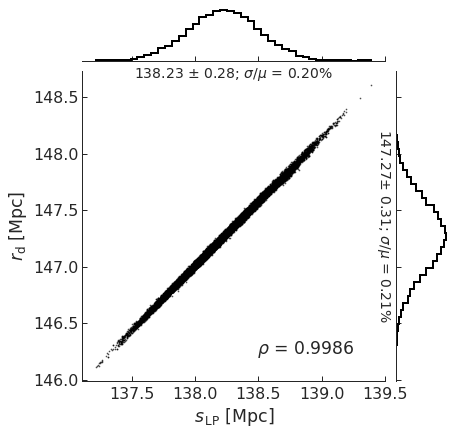

In [45]:
x  = df_lcdm['lp'].values
y = df_lcdm['rdrag*'].values

#idx = np.random.randint(0,len(x),10000)
idx = np.arange(len(x))

labels = [r'$s_{\rm \, LP}$ [Mpc]',
          r'$r_{\rm d}$ [Mpc]']


g = jointplot(x[idx],y[idx], labels,weights_lcdm[idx],
              levels=False, smoothing_beam=0.1, bins=40)

# g.ax_joint.cla()
# g.ax_marg_x.set_xlim(x.min(),x.max())
# g.ax_marg_y.set_ylim(y.min(),y.max())

# g.ax_joint.scatter(x,y,rasterized=True);

plt.savefig('./Figures/Summer 2019/r_drag_vs_r_lp.pdf', dpi=200,
           bbox_inches='tight')

# Starting Plots

## Plotting - basics

In [52]:
plot_dict = dict(lcdm = dict(label=r'Flat $\Lambda CDM$', color='black', ls='solid'),
                omk = dict(label=r'$\Lambda$CDM', color='C0', ls='dashed'),
                w = dict(label=r'Flat $w$CDM', color='C1', ls='dashdot'))

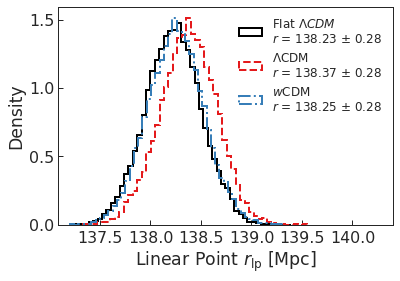

In [17]:
fig, ax = plt.subplots()

label, color, ls = list(plot_dict['lcdm'].values())
plot_hist(ax,df_lcdm.lp,weights_lcdm, label = label,
         color=color, ls=ls, lw=2)

label, color, ls = list(plot_dict['omk'].values())
plot_hist(ax,df_omk.lp,weights_omk, label = label,
         color=color, ls=ls, lw=2)

label, color, ls = list(plot_dict['w'].values())
plot_hist(ax,df_w.lp,weights_w, label = label,
         color=color, ls=ls, lw=2)

# labels
ax.set_xlabel(r'Linear Point $r_{\rm lp}$ [Mpc]')
ax.legend(fontsize='x-small', frameon=False)
ax.set_xlim(right=140.4)


plt.savefig('./Figures/{}/lp_dist_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
            transparent=True)

plt.show()

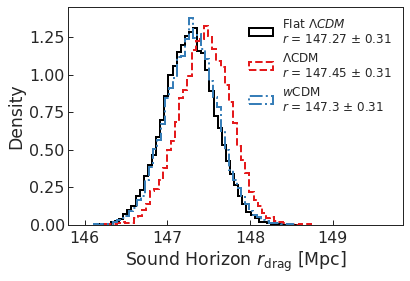

In [18]:
fig, ax = plt.subplots()

label, color, ls = list(plot_dict['lcdm'].values())
plot_hist(ax,df_lcdm['rdrag*'],weights_lcdm, label = label,
         color=color, ls=ls, lw=2)

label, color, ls = list(plot_dict['omk'].values())
plot_hist(ax,df_omk['rdrag*'],weights_omk, label = label,
         color=color, ls=ls, lw=2)

label, color, ls = list(plot_dict['w'].values())
plot_hist(ax,df_w['rdrag*'],weights_w, label = label,
         color=color, ls=ls, lw=2)

# labels
ax.set_xlabel(r'Sound Horizon $r_{\rm drag}$ [Mpc]')
ax.legend(fontsize='x-small', frameon=False)
ax.set_xlim(left=145.8,right=149.85)


plt.savefig('./Figures/{}/rdrag_dist_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
            transparent=True)

plt.show()

### Side by side

In [78]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

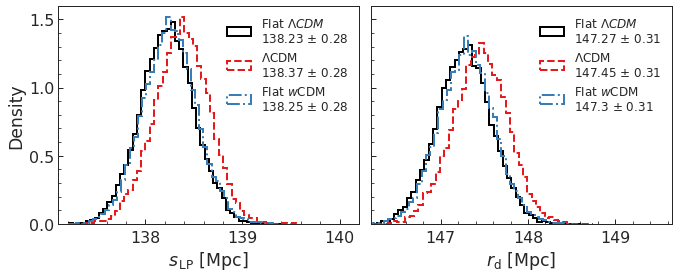

In [86]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(11,4), sharey='row')

# flat lcdm
label, color, ls = list(plot_dict['lcdm'].values())

plot_hist(ax2,df_lcdm['rdrag*'],weights_lcdm, label = label,
         color=color, ls=ls, lw=2)
plot_hist(ax1,df_lcdm.lp,weights_lcdm, label = label,
         color=color, ls=ls, lw=2)
# lcdm
label, color, ls = list(plot_dict['omk'].values())
plot_hist(ax1,df_omk.lp,weights_omk, label = label,
         color=color, ls=ls, lw=2)

plot_hist(ax2,df_omk['rdrag*'],weights_omk, label = label,
         color=color, ls=ls, lw=2)
# flat wcdm
label, color, ls = list(plot_dict['w'].values())
plot_hist(ax1,df_w.lp,weights_w, label = label,
         color=color, ls=ls, lw=2)

plot_hist(ax2,df_w['rdrag*'],weights_w, label = label,
         color=color, ls=ls, lw=2)

# labels
ax1.set_xlabel(r'$s_{\rm \, LP}$ [Mpc]')
ax1.legend(fontsize='x-small', frameon=False)
ax1.set_xlim(left=137.1, right=140.2)


ax2.set_xlabel(r'$r_{\rm d}$ [Mpc]')
ax2.legend(fontsize='x-small', frameon=False)
ax2.set_xlim(left=146.2,right=149.65)


# adjustments
ax2.set_ylabel('')
plt.subplots_adjust(wspace=0.04)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

# save
plt.savefig('./Figures/{}/sLP_rd_dist_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
            transparent=True)

plt.show()

### Are these distributions Gaussian?

In [29]:
from scipy.stats import normaltest, kstest

In [30]:
def bigarr(arr,weights):
    bigarr = []
    for i in range(len(arr)):
        bigarr.append(np.array([arr[i]]*int(weights[i])))
    return np.concatenate(bigarr)

def kstest_norm(arr):
    return kstest(arr,'norm', args=(np.mean(arr), np.std(arr)))

In [31]:
for df, weights in zip([df_lcdm, df_omk, df_w],[weights_lcdm,weights_omk,weights_w]):
    lpbigarr = bigarr(df.lp.values, weights.values)
    print("lp: ")
    print(kstest(lpbigarr,'norm', args=(np.mean(lpbigarr), np.std(lpbigarr))))
    
    lpbigarr = bigarr(df['rdrag*'].values, weights.values)
    print("rd: ")
    print(kstest(lpbigarr,'norm', args=(np.mean(lpbigarr), np.std(lpbigarr))))
    print()
    

lp: 
KstestResult(statistic=0.0038575511789814554, pvalue=0.08313268134244212)
rd: 
KstestResult(statistic=0.006172084105679376, pvalue=0.0005822189108913315)

lp: 
KstestResult(statistic=0.008701791828157723, pvalue=6.682627539565016e-05)
rd: 
KstestResult(statistic=0.009704328033220189, pvalue=5.421912549356802e-06)

lp: 
KstestResult(statistic=0.0050638347668262584, pvalue=0.01807708911323313)
rd: 
KstestResult(statistic=0.006911988575564465, pvalue=0.0003111307758694995)



#### KStest results by sample size

In [32]:
# focus on df_lcdm initially
df = df_lcdm
weights = weights_lcdm
# get big arrays
lpbigarr = bigarr(df.lp.values, weights.values)
rdbigarr = bigarr(df['rdrag*'].values, weights.values)

In [33]:
# doing ks test for various samples

# get different sample sizes
ss = np.int_(np.logspace(3,5,10))
# number of draws per ss
n_draws = 1000

# data to be stored
# ss, lp_stat, lp_pval, rd_stat, rd_pval
cols = ['sample_size', 'lp_stat', 'lp_pval', 'rd_stat', 'rd_pval']
ks_df = pd.DataFrame(np.ones((len(ss)*n_draws, len(cols))), columns=cols)

# insert result row by row
ctr = 0
for sample_size in ss:
    for i in range(n_draws):
        # draw sample
        rd_sample = np.random.choice(rdbigarr, size=sample_size, replace=False)
        lp_sample = np.random.choice(lpbigarr, size=sample_size, replace=False)
        # calculate ks test
        rd_ks = kstest_norm(rd_sample)
        lp_ks = kstest_norm(lp_sample)
        ks_df.iloc[ctr] = [sample_size, lp_ks.statistic, lp_ks.pvalue, rd_ks.statistic, rd_ks.pvalue]
        # update ctr
        ctr += 1

/home/marcio/miniconda3/envs/research/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


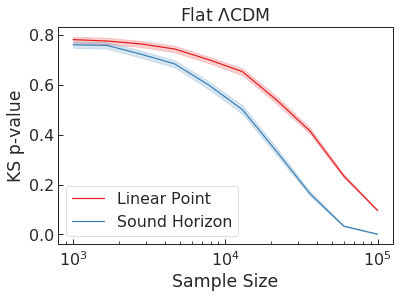

In [34]:
sns.lineplot(x='sample_size', y='lp_pval', data = ks_df, ci = 95, estimator='mean',
             err_style="band", label='Linear Point', markers=True);
sns.lineplot(x='sample_size', y='rd_pval', data = ks_df, ci = 95, estimator='mean',
             err_style="band", label='Sound Horizon', markers=True);
plt.xscale('log')
plt.title('Flat $\Lambda$CDM')
plt.ylabel('KS p-value')
plt.xlabel('Sample Size')

plt.legend(loc = 'lower left')

# plt.savefig('./Figures/Summer 2019/KS_results_lp_rd_flat-LCDM.pdf', dpi=200,
#            bbox_inches='tight')

plt.show()

#### Note
Whenever we use the weights to duplicate rows and create a "big" array, that array is very non-gaussian. If we do not use the weight, the result we get is fairly gaussian. Why? It probably doesn;t mean anything since the posterior is not expected to be Gaussian. You see the same behaviour for omega_c for example, coming straight from Planck's chain.

### Finding point that looks Gaussian for every chain

In [58]:
def test_gaussianity_vs_sample_size(arr, sample_size_step = 1000, p_val_threshold = 0.01, n_draws=100):
    sample_size = len(arr)
    p_val = 0
    n_draws = 100
    while sample_size > 0:
        p_val = 0
        for i in range(n_draws):
            # draw sample
            sample = np.random.choice(arr, size=sample_size, replace=False)
            # calculate ks test
            ks = kstest_norm(sample)
            # get mean_p_val
            p_val += ks.pvalue
        p_val /= n_draws
        if p_val < p_val_threshold:
            sample_size -= sample_size_step
        else:
            print(f'Sample size = {sample_size}, mean p-value = {p_val}')
            break

In [59]:
print("linear_point")
for df, weights, name in zip([df_lcdm, df_omk, df_w],
                             [weights_lcdm,weights_omk,weights_w], 
                             ['flat lcdm', 'lcdm', 'wcdm']):
    arr = bigarr(df.lp.values, weights.values)
    print(f'{name} -> ', end='')
    test_gaussianity_vs_sample_size(arr, sample_size_step=1000, n_draws=100)

linear_point
flat lcdm -> Sample size = 106863, mean p-value = 0.08313268133971333
lcdm -> Sample size = 33056, mean p-value = 0.01214840074214504
wcdm -> Sample size = 91767, mean p-value = 0.018077089112494848


In [60]:
print("r_drag")
for df, weights, name in zip([df_lcdm, df_omk, df_w],
                             [weights_lcdm,weights_omk,weights_w], 
                             ['flat lcdm', 'lcdm', 'wcdm']):
    arr = bigarr(df['rdrag*'].values, weights.values)
    print(f'{name} -> ', end='')
    test_gaussianity_vs_sample_size(arr, sample_size_step=1000, n_draws=100)

r_drag
flat lcdm -> Sample size = 72863, mean p-value = 0.015371165547125221
lcdm -> Sample size = 28056, mean p-value = 0.012797565680689136
wcdm -> Sample size = 59767, mean p-value = 0.013568363135074545


## Cosmology

In [92]:
params_clean = ['lp', 'omegabh2', 'omegach2', 'H0*', 'tau', 'A*', 'ns', 'w', 'omegak']

plot_labels = [r'$s_{\rm LP}$ [Mpc]',
                r'$\omega_b$',
                r'$\omega_c$',
                r'$H_0$',
                r'$\tau$',
                r'$\ln (10^{10} A)$',
                r'$n_s$',
                r'$w$',
                r'$\Omega_k$']

## Flat LCDM 

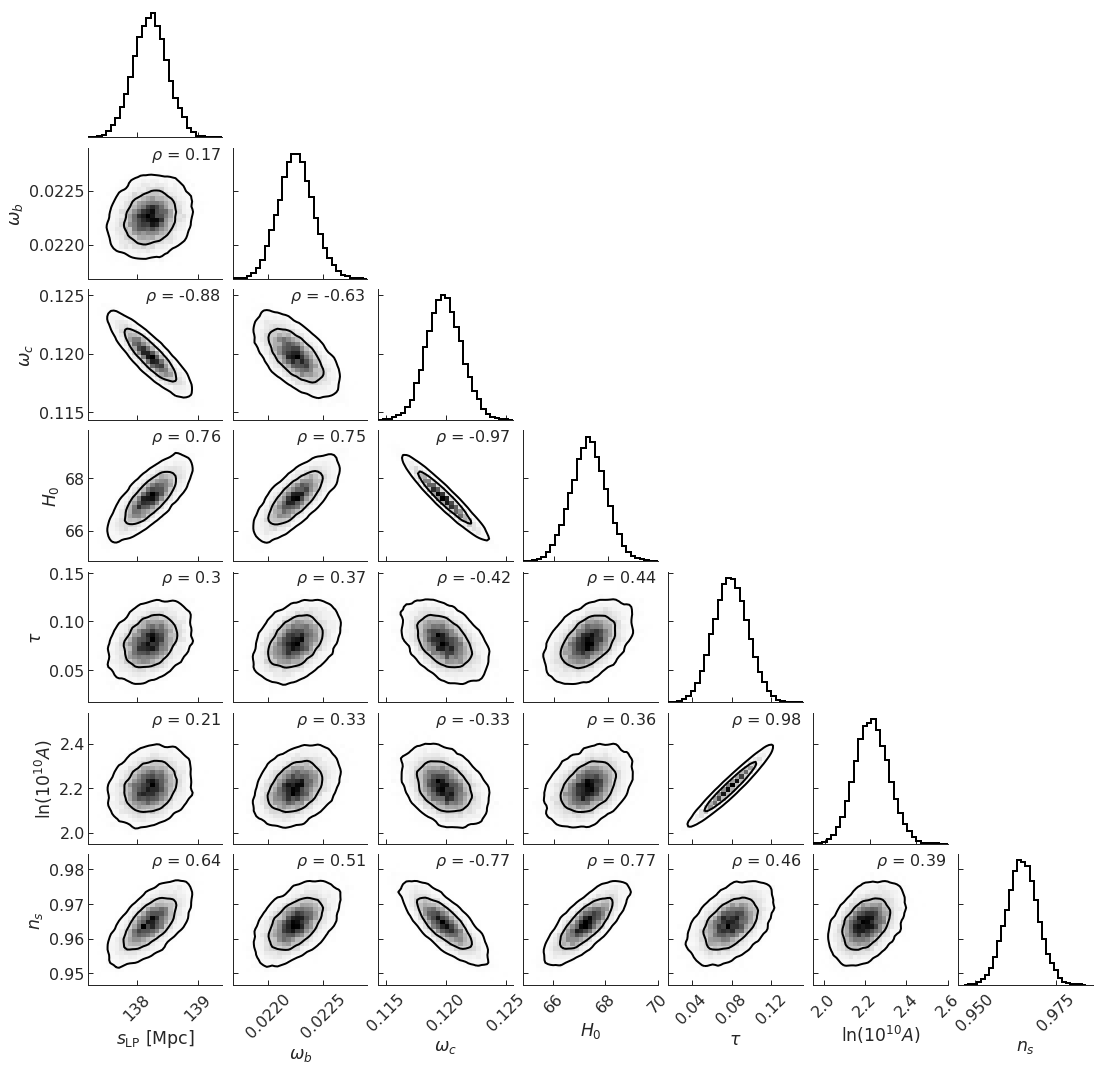

In [94]:
# grid
g = plot_matrix_grid(plot_labels[:-2], size=18)
# plotting curves
label, color, ls = list(plot_dict['lcdm'].values())
g = plot_matrix(g, df_lcdm[params_clean],weights=weights_lcdm, 
                color=color, ls=ls,lw=2)
# hist 2d
g.add_hist2d(df_lcdm[params_clean],30, weights=weights_lcdm)
# corr coeff
g.add_corr_coef(df_lcdm[params_clean], label=r'$\rho$', 
                fontsize=16, decimal_points=2,
               xpos = 0.99, ypos=0.95)
# ticks
ax = g.axes[-1,3]
ax.set_xticks(np.arange(66,71,2))

ax = g.axes[-1,4]
ax.set_xticks(np.arange(0.04,0.13,0.04))

ax = g.axes[-1,5]
ax.set_xticks(np.arange(2,2.6,0.2))
# saving
plt.savefig('./Figures/{}/lp_cosmo_matrix_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
            transparent=True)
plt.show()

##  Joint Plot

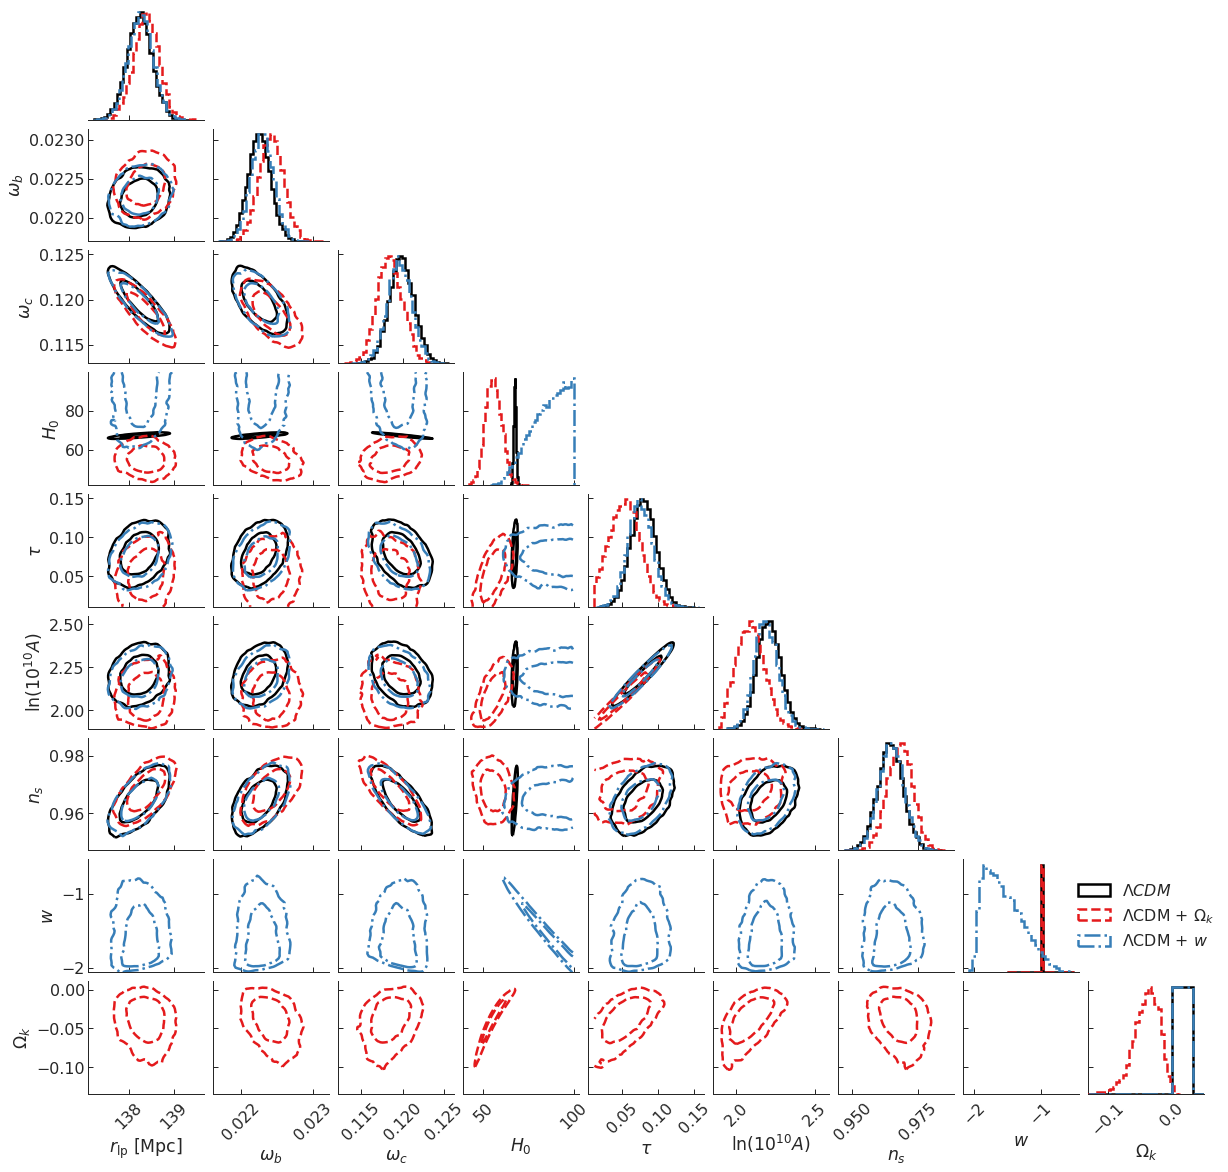

In [17]:
g = plot_matrix_grid(plot_labels, size=20)

label, color, ls = list(plot_dict['lcdm'].values())
g = plot_matrix(g, df_lcdm[params_clean],weights=weights_lcdm, 
                color=color, ls=ls, label=label)

label, color, ls = list(plot_dict['omk'].values())
g = plot_matrix(g, df_omk[params_clean],weights=weights_omk, 
                color=color, ls=ls, label=label)

label, color, ls = list(plot_dict['w'].values())
g = plot_matrix(g, df_w[params_clean],weights=weights_w, 
                color=color, ls=ls, label=label)

g.add_data_legend(frameon=False)

g.axes[-1,-1].set_xlim(-.13,.05)
g.label_ax.set_xlim(left=1e3)
# plt.savefig('./Figures/{}/lp_cosmo_matrix_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
#             transparent=True)
plt.show()

In [103]:
labels_lp = [r'$r_{\rm peak}$ [Mpc]',
          r'$r_{\rm dip}$ [Mpc]',
          r'$r_{\rm lp}$ [Mpc]',
          r'$r_{\rm drag}$ [Mpc]']

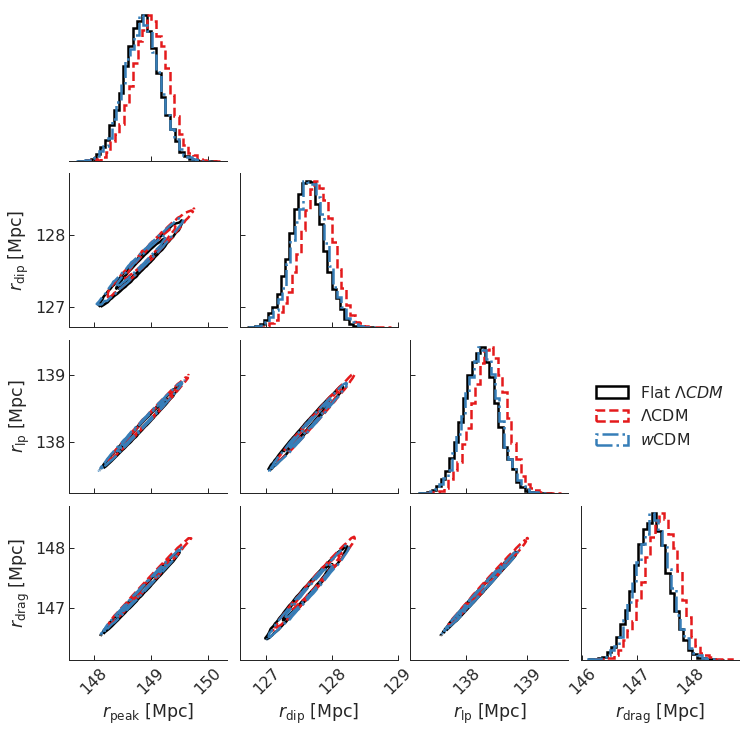

In [104]:
g = plot_matrix_grid(labels_lp, size=12)

label, color, ls = list(plot_dict['lcdm'].values())
g = plot_matrix(g, df_lcdm[params_lp],weights=weights_lcdm,
                color=color, ls=ls, label=label, smoothing_beam = 0)

label, color, ls = list(plot_dict['omk'].values())
g = plot_matrix(g, df_omk[params_lp],weights=weights_omk, 
                color=color, ls=ls, label=label, smoothing_beam = 0)

label, color, ls = list(plot_dict['w'].values())
g = plot_matrix(g, df_w[params_lp],weights=weights_w, 
               color=color, ls=ls, label=label, smoothing_beam = 0)

g.add_data_legend(frameon=False)
g.label_ax.set_xlim(left=1e3)
# plt.savefig('./Figures/{}/lp_cf_rdrag_matrix_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
#             transparent=True)
plt.show()

In [119]:
# flat lcdm: 0.9986
# lcdm: 0.9969
# wcdm: 0.9984

# Auto distributions of lp, cf, rdrag

In [129]:
sns.set_context("poster", font_scale=0.9)

In [130]:
df_lcdm, weights_lcdm = prepare_df(chain_name_lcdm, params, lcdm_defaults)
df_w, weights_w = prepare_df(chain_name_w, params, lcdm_defaults)
df_omk, weights_omk = prepare_df(chain_name_omk, params, lcdm_defaults)

There are 0 NaN values in base_plikHM_TTTEEE_lowTEB_lp.
There are 3 NaN values in base_w_plikHM_TTTEEE_lowTEB_lp.
There are 14 NaN values in base_omegak_plikHM_TTTEEE_lowTEB_lp.
Dropping Int64Index([11635, 12312, 20166], dtype='int64') of  base_omegak_plikHM_TTTEEE_lowTEB_lp.


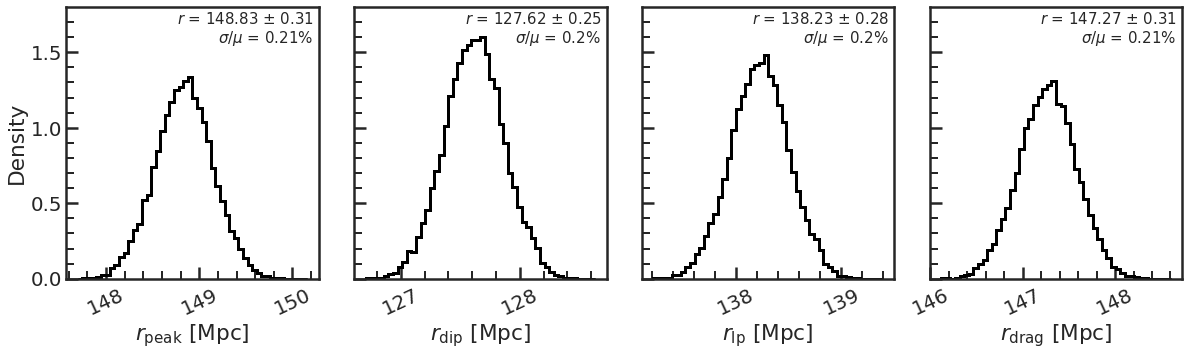

In [131]:
fig, ax = plt.subplots(1,4, figsize=(20,5), sharey=True)
df = df_lcdm.copy()
weights = weights_lcdm.copy()


for i in range(len(params_lp)):
    arr = df[params_lp[i]].values
    plot_hist(ax[i],arr,weights, bins = 50, stats_text=True)
    xticks = np.round(np.linspace(np.min(arr),np.max(arr),4),1)
    #ax[i].set_xticks(xticks)
    ax[i].set_xlabel(labels_lp[i])
    ax[i].tick_params('x', rotation = 25)
    ax[i].minorticks_on()
    if i > 0:
        #xticks = xticks[:]
        ax[i].set_ylabel("")

fig.subplots_adjust(wspace=0.14)
ax[0].set_ylim(0,1.8)
# plt.savefig('./Figures/{}/lp_cf_rdrag_dist.pdf'.format(plot_folder_name), bbox_inches='tight',
#             transparent=True)
plt.show()